In [1]:
#!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [python-Levenshtein]


In [12]:
import pandas as pd
import ast

#working_dir = 'C:/Users/carja/Documents/Capstone/'
working_dir = '/mnt/c/Users/carja/Documents/Capstone/'
df = pd.read_csv(working_dir + 'analyzedTracks.csv')

# remove playlist related columns
df = df.drop(columns=['pos','playlist_num_albums','playlist_num_artists','playlist_num_followers','playlist_collaborative','playlist_pid','album_name','playlist_num_tracks','playlist_name','duration_ms','playlist_pid'])

#split mfcc_shape into x & y size
def unpack_shape(value):
    try:
        if isinstance(value, str):
            value = ast.literal_eval(value)  # convert string to tuple
        if isinstance(value, tuple) and len(value) == 2:
            return value
    except Exception:
        pass
    return (None, None)

df[['mfcc_shape_x', 'mfcc_shape_y']] = df['mfcc_shape'].apply(unpack_shape).apply(pd.Series)
df.drop(columns=['mfcc_shape'], inplace=True)

# remove rows w/out a progression -- most likely audio was correct or absent
df = df.dropna(subset=['progression1'])
#remove duplicate tracks
df = df.drop_duplicates(subset=['artist_name', 'track_name'])

# Store track_name and artist_name separately
meta_cols = df[['track_name', 'artist_name']].copy()
df_cleaned = df.drop(['track_name', 'artist_name'], axis=1)
df_cleaned.head()


,harmony_degree,tonic,mode,tempo,spectral_contrast_mean,spectral_contrast_var,spectral_centroid_mean,spectral_centroid_var,spectral_flatness_mean,spectral_flatness_var,progression1,progression2,mfcc_shape_x,mfcc_shape_y
0,6.297153,F,major,129.199219,21.106346,11.337712,2640.301228,890.561052,0.083839,0.205738,"['v', 'vi', 'ii', 'iio', 'bVII', 'vi', 'ii', 'I']","['ii', 'I', 'bVII', 'ii', 'iio', 'bVII', 'ii',...",13.0,7656.0
1,6.791351,A,major,161.499023,21.820560,11.282618,2693.961413,1082.618798,0.036503,0.072091,"['i', 'iv', 'i', 'iio']","['iv', 'i', 'iio', 'i']",13.0,10429.0
2,5.641401,A,minor,143.554688,21.415842,11.880545,2628.981838,809.000785,0.048472,0.124956,"['iv', 'bVII', 'i', 'iv', 'bVII', 'i']","['i', 'iv', 'bVII', 'i', 'iv']",13.0,9565.0
3,8.635023,A,minor,143.554688,21.660702,11.768187,3254.803701,926.430375,0.066690,0.099132,"['bVI', 'v', 'bVI', 'v', 'bVI', 'v']","['V', 'bVII', 'V', 'bVII', 'i', 'I', 'iio', 'I']",13.0,10439.0
4,5.192371,E,major,135.999178,23.254460,10.982775,2546.516052,884.615807,0.038849,0.126105,"['IV', 'V', 'biv', 'I']","['I', 'vi', 'IV', 'V', 'biv']",13.0,9648.0


In [13]:
#Normalize numerical features
from sklearn.preprocessing import StandardScaler

num_cols = ['harmony_degree', 'tempo', 'mfcc_shape_x', 'mfcc_shape_y', 'spectral_contrast_mean', 'spectral_contrast_var',
            'spectral_centroid_mean', 'spectral_centroid_var',
            'spectral_flatness_mean', 'spectral_flatness_var']
scaler = StandardScaler()
X_num = scaler.fit_transform(df_cleaned[num_cols])

X_num_df = pd.DataFrame(X_num, columns=num_cols, index=df_cleaned.index)
X_num_df.head()

,harmony_degree,tempo,mfcc_shape_x,mfcc_shape_y,spectral_contrast_mean,spectral_contrast_var,spectral_centroid_mean,spectral_centroid_var,spectral_flatness_mean,spectral_flatness_var
0,1.023115,0.385564,0.0,-0.667090,-1.344018,-0.266460,0.690353,0.405695,1.892069,2.033252
1,1.344542,1.662400,0.0,-0.056772,-0.739853,-0.341703,0.798901,1.356856,0.092205,-0.177993
2,0.596614,0.953047,0.0,-0.246933,-1.082210,0.474896,0.667455,0.001769,0.547286,0.696690
3,2.543668,0.953047,0.0,-0.054571,-0.875079,0.321448,1.933422,0.583337,1.239999,0.269416
4,0.304564,0.654372,0.0,-0.228665,0.473107,-0.751204,0.500636,0.376251,0.181390,0.715690


In [14]:
#One Hot Encode Categoricals
X_cat = pd.get_dummies(df_cleaned[['tonic', 'mode']])

X_cat_df = pd.DataFrame(X_cat, columns=['tonic', 'mode'], index=df_cleaned.index)
X_cat.head()

,tonic_A,tonic_A#,tonic_B,tonic_C,tonic_C#,tonic_D,tonic_D#,tonic_E,tonic_F,tonic_F#,tonic_G,tonic_G#,mode_major,mode_minor
0,False,False,False,False,False,False,False,False,True,False,False,False,True,False
1,True,False,False,False,False,False,False,False,False,False,False,False,True,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True,False,False,False,False,True,False


In [18]:
import ast
import numpy as np
import pandas as pd
from Levenshtein import distance
from sklearn.manifold import MDS

def normalize_dist(a, b):
    if not a or not b:
        return 1.0
    max_len = max(len(a), len(b))
    return distance(a, b) / max_len if max_len > 0 else 0

def safe_eval_progression(prog_str, index, label):
    if prog_str is None or not isinstance(prog_str, str):
        return ''
    try:
        val = ast.literal_eval(prog_str)
        return ' '.join(val) if isinstance(val, list) else ''
    except (ValueError, SyntaxError) as e:
        print(f"[Warning] Malformed {label} at index {index}: {e}")
        return ''

def compute_progression_distance_matrix(df):
    n = len(df)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        p1_i = safe_eval_progression(df.iloc[i]['progression1'], i, 'progression1')
        p2_i = safe_eval_progression(df.iloc[i]['progression2'], i, 'progression2')

        for j in range(i + 1, n):
            p1_j = safe_eval_progression(df.iloc[j]['progression1'], j, 'progression1')
            p2_j = safe_eval_progression(df.iloc[j]['progression2'], j, 'progression2')

            d1 = normalize_dist(p1_i, p1_j)
            d2 = normalize_dist(p2_i, p2_j)
            d3 = normalize_dist(p1_i, p2_j)
            d4 = normalize_dist(p2_i, p1_j)

            min_dist = min(d1, d2, d3, d4)
            dist_matrix[i, j] = dist_matrix[j, i] = min_dist

    return dist_matrix


# Embed to N-dimensional space (e.g., 2D or 5D)
D_prog = compute_progression_distance_matrix(df_cleaned)

similarity_matrix = 1 - D_prog
similarity_matrix = np.nan_to_num(similarity_matrix, nan=0)  # treat NaN similarity as 0 (no similarity)
embedding = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
prog_embedded = embedding.fit_transform(D_prog)

In [19]:
from sklearn.decomposition import TruncatedSVD

"""
Prints the top `top_features_per_factor` contributing features for the first `top_n` SVD components.
"""
def print_top_svd_factors(svd, feature_names, top_n=5):
    for i in range(min(top_n, svd.components_.shape[0])):
        component = svd.components_[i]
        top_indices = np.argsort(np.abs(component))[::-1]
        top_features = [(feature_names[j], component[j]) for j in top_indices]

        print(f"\nSVD Factor {i+1}:")
        for name, weight in top_features:
            print(f"  {name}: {weight:.4f}")

w_num = 0.15     # weight for spectral/numerical features
w_cat = 0.15   # weight for categorical features
w_prog = 0.7   # weight for progression embeddings

X_total = np.hstack([
    X_num * w_num,
    X_cat * w_cat,
    prog_embedded * w_prog
])
svd = TruncatedSVD(n_components=10)
X_reduced = svd.fit_transform(X_total)

## Assemble the column names
# Numeric column names
num_col_names = list(df_cleaned[num_cols].columns)
# Categorical column names
cat_col_names = list(X_cat.columns)
# Progression embedding column names
prog_col_names = [f'prog_embedded_{i}' for i in range(prog_embedded.shape[1])]
feature_names = num_col_names + cat_col_names + prog_col_names

print_top_svd_factors(svd, feature_names, top_n=5)


SVD Factor 1:
  spectral_flatness_mean: 0.4999
  spectral_contrast_mean: -0.4838
  spectral_centroid_mean: 0.4127
  harmony_degree: 0.4023
  spectral_flatness_var: 0.3224
  spectral_centroid_var: 0.1902
  prog_embedded_0: 0.1471
  spectral_contrast_var: 0.1034
  mode_major: -0.0739
  mode_minor: 0.0692
  prog_embedded_1: -0.0267
  tempo: 0.0140
  tonic_D: -0.0118
  tonic_F: -0.0084
  prog_embedded_2: 0.0078
  tonic_A: 0.0068
  mfcc_shape_y: -0.0054
  tonic_F#: 0.0050
  tonic_G: 0.0040
  tonic_D#: 0.0039
  tonic_B: 0.0036
  tonic_G#: -0.0031
  tonic_C: -0.0023
  tonic_E: -0.0022
  tonic_C#: -0.0001
  tonic_A#: -0.0001
  mfcc_shape_x: -0.0000

SVD Factor 2:
  spectral_flatness_var: 0.5251
  spectral_centroid_var: 0.4451
  harmony_degree: -0.3478
  spectral_contrast_var: -0.3402
  spectral_flatness_mean: 0.2936
  spectral_centroid_mean: -0.2250
  prog_embedded_2: 0.2130
  prog_embedded_0: -0.1981
  spectral_contrast_mean: 0.1880
  mfcc_shape_y: -0.1087
  mode_major: 0.1001
  mode_minor: 

Best number of clusters: 8


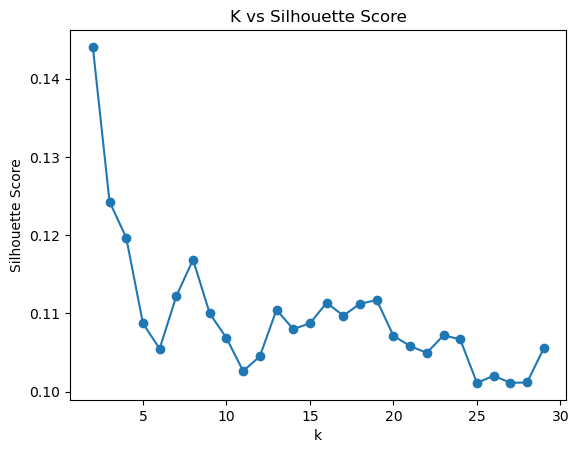

In [21]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

MIN_CLUSTER = 5

def search_best_k(X, k_range=range(2, 21), metric='silhouette'):
    best_k = None
    best_score = -np.inf
    scores = []

    for k in k_range:
        # Cluster the data using KMeans
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        # Score clustering quality
        if metric == 'silhouette':
            score = silhouette_score(X, labels)
        elif metric == 'calinski':
            from sklearn.metrics import calinski_harabasz_score
            score = calinski_harabasz_score(X, labels)
        elif metric == 'davies':
            from sklearn.metrics import davies_bouldin_score
            score = -davies_bouldin_score(X, labels)  # negate since lower is better
        else:
            raise ValueError("Unknown metric")

        scores.append((k, score))

        if k > MIN_CLUSTER and score > best_score:
            best_k = k
            best_score = score

    return best_k, scores

# find the K that maximizes grouping among the tracks
best_k, score_list = search_best_k(X_reduced, k_range=range(2, 30), metric='silhouette')
print("Best number of clusters:", best_k)

# Optional: Plot score trend
import matplotlib.pyplot as plt

ks, values = zip(*score_list)
plt.plot(ks, values, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('K vs Silhouette Score')
plt.show()

In [22]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=best_k)
knn.fit(X_reduced)
distances, indices = knn.kneighbors(X_reduced)

In [50]:
import random

def recommend_tracks(track_index, distances, indices, track_info, n_recs):
    recs = []
    for i in range(1, min(n_recs + 1, len(indices[track_index]))):  # Skip index 0 (the track itself)
        idx = indices[track_index][i]
        recs.append({
            'track_name': track_info.iloc[idx]['track_name'],
            'artist_name': track_info.iloc[idx]['artist_name'],
            'distance': distances[track_index][i]
        })
    return recs

def recommendation(artist, track, df):
    match = df[(df['artist_name'] == artist) & (df['track_name'] == track)]
    # Get index
    if not match.empty:
        track_index = match.index[0]  # or list(match.index) if multiple
        return recommend_tracks(track_index, distances, indices, df, best_k)
    else:
        return None

def random_recommendation(df):
    track_index = random.randint(0, len(df))
    artist = df.loc[track_index, 'artist_name']
    track = df.loc[track_index, 'track_name']
    return recommendation(artist, track, df), artist, track

# Append artist & title back to the data to handle queries
df_result = pd.concat([df_cleaned, meta_cols], axis=1)

# handle a specific inquiry
recs = recommendation('natori', 'IN_MY_HEAD', df_result)
print(f"Recommendation for: 'IN_MY_HEAD' by 'natori'")
for rec in recs:
    print(f"   {rec['track_name']} by {rec['artist_name']} (distance: {rec['distance']:.3f})")

#make a random recommendation
recs, artist, track = random_recommendation(df_result)
print(f"\nRecommendation for: '{track}' by '{artist}'")
for rec in recs:
    print(f"   {rec['track_name']} by {rec['artist_name']} (distance: {rec['distance']:.3f})")

Recommendation for: 'IN_MY_HEAD' by 'natori'
   The Time Is Now by John Cena (distance: 0.224)
   Fetish (feat. Gucci Mane) by Selena Gomez (distance: 0.242)
   MIRROR by Ado (distance: 0.252)
   Drop That - Original Mix by Caked Up (distance: 0.256)
   Overdose by natori (distance: 0.264)
   Ari Ari (Part 2) by Bombay Rockers (distance: 0.265)
   Asian Jake Paul by iDubbbz (distance: 0.271)

Recommendation for: 'George Benson - Breezin 1976 (Original Studio Version)' by 'JazzBreakTV'
   [They Long To Be] Close To You by Carpenters (distance: 0.288)
   On And On by Stephen Bishop - Topic (distance: 0.301)
   For Your Eyes Only by Sheena Easton (distance: 0.303)
   Extreme - More Than Words (Official Music Video) by OfficiallyExtreme (distance: 0.305)
   You've Really Got A Hold On Me by Smokey Robinson (distance: 0.318)
   Dance with Me by Orleans - Topic (distance: 0.324)
   Enna Sona by A.R. Rahman (distance: 0.324)
